In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/train.csv


In [2]:
df = pd.read_csv('/kaggle/input/dataset/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

# ****Preprocessing****

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']

In [7]:
y = df[df.columns[2:]].values

In [8]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [9]:
MAX_FEATURES = 200000

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,output_mode='int',output_sequence_length=1800)

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [17]:
vectorized_text[0]

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([645,  76,   2, ...,   0,   0,   0])>

In [18]:
import tensorflow as tf

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))
test

<_TakeDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

# ********Create Sequential Model********

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [23]:
model = Sequential()

model.add(Embedding(MAX_FEATURES+1,32))

model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(6,activation='sigmoid'))

In [24]:
model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])

In [25]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
tf.debugging.set_log_device_placement(True)

In [27]:
history = model.fit(train,validation_data=val,epochs=4)

Epoch 1/4
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 496s 140ms/step - accuracy: 0.9426 - loss: 0.0919 - val_accuracy: 0.9943 - val_loss: 0.0443
Epoch 2/4
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 488s 140ms/step - accuracy: 0.9928 - loss: 0.0508 - val_accuracy: 0.9947 - val_loss: 0.0414
Epoch 3/4
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 489s 140ms/step - accuracy: 0.9850 - loss: 0.0410 - val_accuracy: 0.9945 - val_loss: 0.0366
Epoch 4/4
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 489s 140ms/step - accuracy: 0.9726 - loss: 0.0366 - val_accuracy: 0.9933 - val_loss: 0.0323


In [28]:
history.history

{'accuracy': [0.9834437966346741,
  0.9896042346954346,
  0.9823424220085144,
  0.9777131080627441],
 'loss': [0.06459951400756836,
  0.04730495065450668,
  0.041232120245695114,
  0.03678420931100845],
 'val_accuracy': [0.9942640662193298,
  0.9946715235710144,
  0.994483470916748,
  0.9933237433433533],
 'val_loss': [0.04429874196648598,
  0.0414012148976326,
  0.036649998277425766,
  0.03229845315217972]}

In [30]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

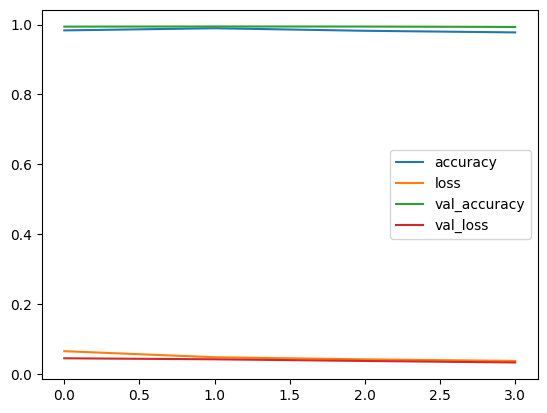

In [39]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()


# ****Make Predictions****

In [83]:
input_text = vectorizer("")

In [84]:
np.array([input_text]).shape

(1, 1800)

In [85]:
res = model.predict(np.array([input_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [90]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [88]:
(res>0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

# ****Evaluate Model****

In [108]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision , Recall

In [109]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [110]:
for batch in test.as_numpy_iterator():
    X_true,y_true = batch

    y_hat = model.predict(X_true,verbose=0)
    y_true = y_true.flatten()
    y_hat = y_hat.flatten()

    pre.update_state(y_true, y_hat)
    re.update_state(y_true, y_hat)
    acc.update_state(y_true, y_hat)
    

In [111]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8600619435310364, Recall:0.7783693075180054, Accuracy:0.34939759969711304


# ****Test and Gradio****

In [112]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 35.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 65.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00


In [115]:
import gradio as gr

In [116]:
model.save('toxicity.keras')

In [125]:
def comment_score(comment):
    vectorized_comment = vectrizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx,col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text    

In [124]:
for idx,col in enumerate(df.columns[2:]):
    print(idx,col)

0 toxic
1 severe_toxic
2 obscene
3 threat
4 insult
5 identity_hate


In [ ]:
interface = gr.Interface(fn=comment_score,inputs=gr.Textbox(lines=2, placeholder='Comment to score'),outputs=gr.Textbox())

In [ ]:
interface.launch(share=True)